In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%mkdir data/
%cp -r /content/drive/My\ Drive/sem_seg/data/* data/

In [5]:
! unzip /content/data/ade20k-hrnetv2-c1/output.zip -d /content/data/ade20k-hrnetv2-c1/output
! unzip /content/data/ade20k-hrnetv2-c1/pert_model_1.zip -d /content/data/ade20k-hrnetv2-c1/pert
! unzip /content/data/ade20k-mobilenetv2dilated-c1_deepsup/output.zip -d /content/data/ade20k-mobilenetv2dilated-c1_deepsup/output
! unzip /content/data/ade20k-mobilenetv2dilated-c1_deepsup/pert_model_1.zip -d /content/data/ade20k-mobilenetv2dilated-c1_deepsup/pert
! unzip /content/data/ade20k-resnet50dilated-ppm_deepsup/output.zip -d /content/data/ade20k-resnet50dilated-ppm_deepsup/output
! unzip /content/data/ade20k-resnet50dilated-ppm_deepsup/pert_model_1.zip -d /content/data/ade20k-resnet50dilated-ppm_deepsup/pert

Archive:  /content/data/ade20k-hrnetv2-c1/output.zip
   creating: /content/data/ade20k-hrnetv2-c1/output/output/
   creating: /content/data/ade20k-hrnetv2-c1/output/output/pred/
 extracting: /content/data/ade20k-hrnetv2-c1/output/output/pred/pert_image_ADE_val_00000063.png  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/orig_pred_ADE_val_00000015.npy  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/pert_image_ADE_val_00000078.png  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/pert_pred_ADE_val_00000002.png.npy  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/orig_image_ADE_val_00000032.png  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/orig_pred_ADE_val_00000036.npy  
 extracting: /content/data/ade20k-hrnetv2-c1/output/output/pred/pert_image_ADE_val_00000069.png  
  inflating: /content/data/ade20k-hrnetv2-c1/output/output/pred/pert_pred_ADE_val_00000067.png.npy  
  inflating: /content/data/ade20k-

In [0]:
! find /content/data/ade20k-hrnetv2-c1/pert/data/pert  -printf "%f\n" >> /content/filenames.txt

In [0]:
%mkdir data/images
%mkdir data/images/train
%mkdir data/images/val
%mkdir data/images/train/adv
%mkdir data/images/train/real
%mkdir data/images/val/adv
%mkdir data/images/val/real

In [0]:
! rm -rf data/images

In [0]:
model_1 = 'ade20k-hrnetv2-c1'
model_2 = 'ade20k-mobilenetv2dilated-c1_deepsup'
model_3 = 'ade20k-resnet50dilated-ppm_deepsup'

with open('/content/filenames.txt', 'r') as f:
    filenames = f.readlines()

    for i, fname in enumerate(filenames[1:]):
        fname = fname.strip().split('.')[0]
        adv_1 = np.load('/content/data/' + model_1 + '/output/output/pred/pert_pred_' + fname + '.png.npy')
        adv_2 = np.load('/content/data/'+ model_2 + '/output/output/pred/pert_pred_' + fname + '.png.npy')
        adv_3 = np.load('/content/data/' + model_3 + '/output/output/pred/pert_pred_' + fname + '.png.npy')

        image = np.stack((adv_1[:, :, np.newaxis], adv_2[:, :, np.newaxis], adv_3[:, :, np.newaxis]), axis=2)

        if i < int(0.80 * len(filenames[1:])):
            Image.fromarray(image.squeeze(3).astype(np.uint8)).save(os.path.join('/content/data/images/train/adv/', fname + '.png')) 
        else:
            Image.fromarray(image.squeeze(3).astype(np.uint8)).save(os.path.join('/content/data/images/val/adv/', fname + '.png')) 

        real_1 = np.load('/content/data/' + model_1 + '/output/output/pred/orig_pred_' + fname + '.npy')
        real_2 = np.load('/content/data/'+ model_2 + '/output/output/pred/orig_pred_' + fname + '.npy')
        real_3 = np.load('/content/data/' + model_3 + '/output/output/pred/orig_pred_' + fname + '.npy')

        image = np.stack((real_1[:, :, np.newaxis], real_2[:, :, np.newaxis], real_3[:, :, np.newaxis]), axis=2)

        if i < int(0.80 * len(filenames[1:])):
            Image.fromarray(image.squeeze(3).astype(np.uint8)).save(os.path.join('/content/data/images/train/real/', fname + '.png'))
        else:
            Image.fromarray(image.squeeze(3).astype(np.uint8)).save(os.path.join('/content/data/images/val/adv/', fname + '.png'))  

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



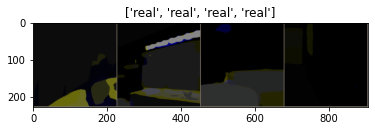

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8109 Acc: 0.5062
val Loss: 0.4802 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.9447 Acc: 0.5563
val Loss: 0.3927 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.9129 Acc: 0.5687
val Loss: 3.4622 Acc: 0.0000

Epoch 3/24
----------
train Loss: 0.8240 Acc: 0.5687
val Loss: 0.6475 Acc: 0.8500

Epoch 4/24
----------
train Loss: 0.7484 Acc: 0.6125
val Loss: 0.3824 Acc: 0.8500

Epoch 5/24
----------
train Loss: 0.8424 Acc: 0.5750
val Loss: 0.5763 Acc: 0.7000

Epoch 6/24
----------
train Loss: 0.5649 Acc: 0.7438
val Loss: 1.5588 Acc: 0.0500

Epoch 7/24
----------
train Loss: 0.6093 Acc: 0.6938
val Loss: 1.5897 Acc: 0.0500

Epoch 8/24
----------
train Loss: 0.6285 Acc: 0.6562
val Loss: 1.3608 Acc: 0.1500

Epoch 9/24
----------
train Loss: 0.6362 Acc: 0.6438
val Loss: 0.8325 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.5514 Acc: 0.7500
val Loss: 1.6394 Acc: 0.0000

Epoch 11/24
----------
train Loss: 0.6116 Acc: 0.7063
val Loss: 1.1570 Acc: 0.2000

Epoch 12/24
----------
t

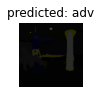

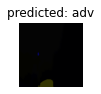

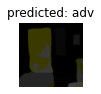

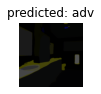

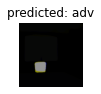

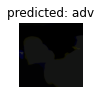

In [18]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()